In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Flatten
import shap

C:\Users\otdi3\anaconda3\envs\hybrid_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
data = data[['Close']]
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2018-01-02,40.304173
2018-01-03,40.297161
2018-01-04,40.484341
2018-01-05,40.945263
2018-01-08,40.793175


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 60)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [7]:
inputs = Input(shape=(X_train.shape[1],1))

lstm_out = LSTM(50, return_sequences=True)(inputs)

attention = Attention()([lstm_out, lstm_out])

flatten = Flatten()(attention)

output = Dense(1)(flatten)

model = Model(inputs, output)

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0180
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0031
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030


In [8]:
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [9]:
errors = abs(y_test - predictions)
threshold = errors.mean() + 2*errors.std()
anomalies = errors > threshold

print("Nombre d'anomalies :", anomalies.sum())

Nombre d'anomalies : 1


In [10]:
import shap

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [11]:
def f(x):
    x = x.reshape((x.shape[0], 60, 1))
    return model.predict(x)

In [12]:
explainer = shap.KernelExplainer(f, X_train_flat[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [13]:
shap_values = explainer.shap_values(X_test_flat[:3])

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step


 33%|████████████████████████████                                                        | 1/3 [00:15<00:31, 15.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:33<00:16, 16.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.79s/it]


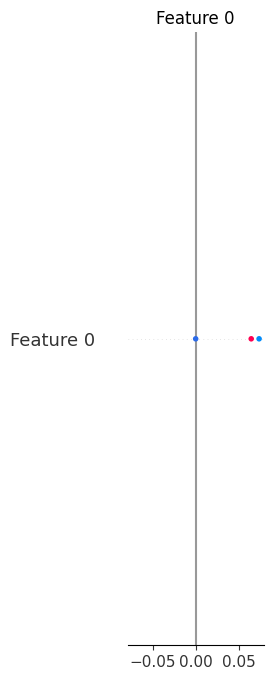

In [15]:
shap.summary_plot(shap_values, X_test_flat[:3])

In [20]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------ --------------------------- 2.6/8.1 MB 15.1 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 21.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 16.8 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 10.3 MB/s  0:00:00
Using cached pyparsing-3.3.2-py3-none-any.whl (122 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- ---

In [18]:
model.save("hybrid_model.h5")

In [20]:
model.save("hybrid_model.keras")